Downloading the data

In [ ]:
!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz
!rm -r aclImdb/train/unsup

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  5595k      0  0:00:14  0:00:14 --:--:-- 10.9M


Preparing the data

In [ ]:
import os, pathlib, shutil, random
from tensorflow import keras
batch_size = 32
base_dir = pathlib.Path("aclImdb")
val_dir = base_dir / "val"
train_dir = base_dir / "train"
for category in ("neg", "pos"):
    if not os.path.exists(val_dir / category):
        os.makedirs(val_dir / category)
    files = os.listdir(train_dir / category)
    random.Random(1337).shuffle(files)
    num_val_samples = int(0.2 * len(files))
    val_files = files[-num_val_samples:]
    for fname in val_files:
        shutil.move(train_dir / category / fname,
                    val_dir / category / fname)

train_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/train", batch_size=batch_size, validation_split=0.01, subset="training", seed=1337
)
val_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/val", batch_size=batch_size, validation_split=0.999, subset="validation", seed=1337
)
test_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/test", batch_size=batch_size
)
text_only_train_ds = train_ds.map(lambda x, y: x)

Found 20000 files belonging to 2 classes.
Using 19800 files for training.
Found 5000 files belonging to 2 classes.
Using 4995 files for validation.
Found 25000 files belonging to 2 classes.


Preparing integer sequence datasets

In [ ]:
from tensorflow.keras import layers

max_length = 150
max_tokens = 10000
text_vectorization = layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=max_length,
)
text_vectorization.adapt(text_only_train_ds)

int_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4).take(100)
int_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4).take(10000)
int_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

A sequence model built on one-hot encoded vector sequences

In [ ]:
import tensorflow as tf
inputs = keras.Input(shape=(None,), dtype="int64")
embedded = tf.one_hot(inputs, depth=max_tokens)
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 tf.one_hot (TFOpLambda)     (None, None, 10000)       0         
                                                                 
 bidirectional (Bidirection  (None, 64)                2568448   
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 2568513 (9.80 MB)
Trainable params: 2568513 (9.80 MB)
Non-trainable params: 0 (0.00 Byte)
_______________________

Training a first basic sequence model

Epoch 1/10
100/100 [==============================] - 68s 170ms/step - loss: 0.1347 - accuracy: 0.9553 - val_loss: 0.5417 - val_accuracy: 0.7850
Epoch 2/10
100/100 [==============================] - 18s 178ms/step - loss: 0.0897 - accuracy: 0.9734 - val_loss: 0.5699 - val_accuracy: 0.7882
Epoch 3/10
100/100 [==============================] - 17s 168ms/step - loss: 0.0696 - accuracy: 0.9766 - val_loss: 0.6405 - val_accuracy: 0.7786
Epoch 4/10
100/100 [==============================] - 17s 170ms/step - loss: 0.0672 - accuracy: 0.9772 - val_loss: 1.1037 - val_accuracy: 0.7092
Epoch 5/10
100/100 [==============================] - 16s 165ms/step - loss: 0.0621 - accuracy: 0.9803 - val_loss: 0.6762 - val_accuracy: 0.7612
Epoch 6/10
100/100 [==============================] - 16s 162ms/step - loss: 0.0455 - accuracy: 0.9850 - val_loss: 0.6805 - val_accuracy: 0.7636
Epoch 7/10
100/100 [==============================] - 17s 171ms/step - loss: 0.0392 - accuracy: 0.9900 - val_loss: 0.9123 - val_ac

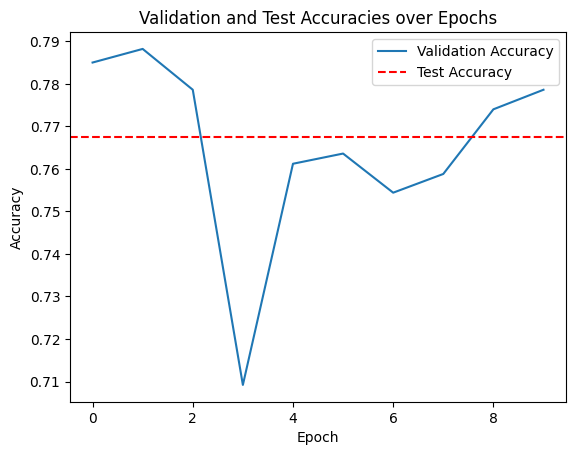

In [ ]:
!pip install matplotlib
import tensorflow.keras as keras
import matplotlib.pyplot as plt

# Assuming model is already defined and compiled
callbacks = [
    keras.callbacks.ModelCheckpoint("one_hot_bidir_lstm.keras",
                                    save_best_only=True)
]
history = model.fit(int_train_ds, validation_data=int_val_ds, epochs=10, callbacks=callbacks)

# Load the best model saved during training
model = keras.models.load_model("one_hot_bidir_lstm.keras")

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(int_test_ds)

# Print the validation and test accuracy
print(f"Validation accuracy: {history.history['val_accuracy'][-1]:.3f}")
print(f"Test accuracy: {test_accuracy:.3f}")

# Plot validation and test accuracies
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.axhline(y=test_accuracy, color='r', linestyle='--', label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation and Test Accuracies over Epochs')
plt.legend()
plt.show()

Instantiating an Embedding layer

In [ ]:
from tensorflow.keras import layers
max_tokens = 10000
embedding_layer = layers.Embedding(input_dim=max_tokens, output_dim=256)

Model that uses an Embedding layer trained from scratch

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  3030k      0  0:00:27  0:00:27 --:--:-- 7607k
Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 256)         2560000   
                                                                 
 bidirectional (Bidirection  (None, 64)                73984     
 al)                                                             
                             

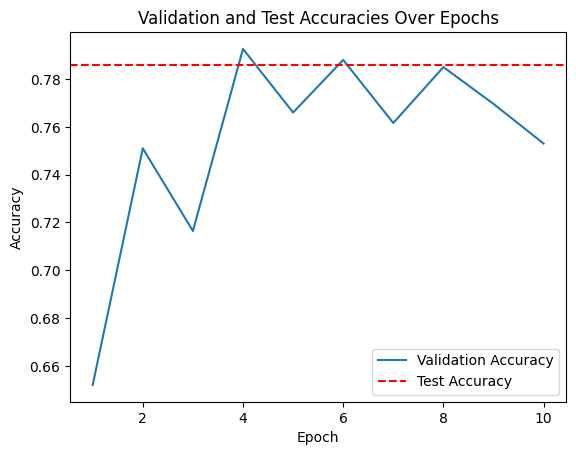

In [ ]:
import os
import pathlib
import random
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers

# Download the data
!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz
!rm -r aclImdb/train/unsup

# Define directories
base_dir = pathlib.Path("aclImdb")
train_dir = base_dir / "train"
test_dir = base_dir / "test"

# Create train, val, and test datasets
batch_size = 32
max_length = 150
max_tokens = 10000

# Training dataset
train_ds = keras.utils.text_dataset_from_directory(
    directory=train_dir,
    batch_size=batch_size,
    validation_split=0.2,
    subset="training",
    seed=1337,
    label_mode="binary",
)

# Validation dataset
val_ds = keras.utils.text_dataset_from_directory(
    directory=train_dir,
    batch_size=batch_size,
    validation_split=0.2,
    subset="validation",
    seed=1337,
    label_mode="binary",
)

# Test dataset
test_ds = keras.utils.text_dataset_from_directory(
    directory=test_dir,
    batch_size=batch_size,
    label_mode="binary",
)

# Define integer sequence datasets
text_only_train_ds = train_ds.map(lambda x, y: x)

# Prepare integer sequence datasets
text_vectorization = layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=max_length,
)
text_vectorization.adapt(text_only_train_ds)

int_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4
).take(100)

int_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4
).take(10000)

int_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4
).take(10000)

# Model definition
inputs = keras.Input(shape=(None,), dtype="int64")
embedded = layers.Embedding(input_dim=max_tokens, output_dim=256)(inputs)
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

# Model training
callbacks = [
    keras.callbacks.ModelCheckpoint("embeddings_bidir_gru.keras",
                                    save_best_only=True)
]
history = model.fit(int_train_ds, validation_data=int_val_ds, epochs=10, callbacks=callbacks)

# Load the best model and evaluate on the test set
model = keras.models.load_model("embeddings_bidir_gru.keras")
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

# Extract validation and test accuracies from history
val_acc = history.history['val_accuracy']
test_acc = model.evaluate(int_test_ds)[1]

# Plotting
plt.plot(range(1, len(val_acc) + 1), val_acc, label='Validation Accuracy')
plt.axhline(y=test_acc, color='r', linestyle='--', label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation and Test Accuracies Over Epochs')
plt.legend()
plt.show()

Using an Embedding layer with masking enabled

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_1 (Embedding)     (None, None, 256)         2560000   
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                73984     
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 2634049 (10.05 MB)
Trainable params: 2634049 (10.05 MB)
Non-trainable params: 0 (0.00 Byte)
___________________

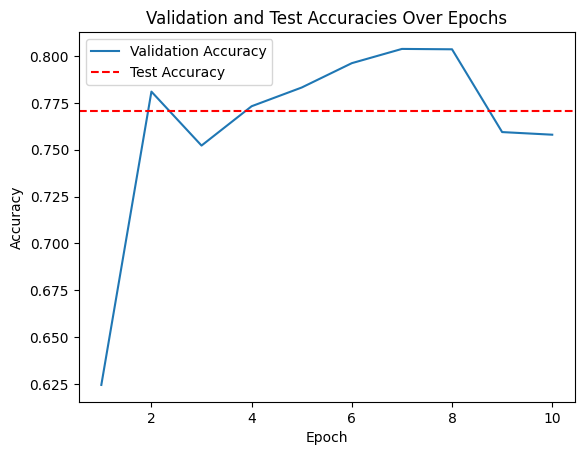

In [ ]:
import matplotlib.pyplot as plt

inputs = keras.Input(shape=(None,), dtype="int64")
embedded = layers.Embedding(
    input_dim=max_tokens, output_dim=256, mask_zero=True)(inputs)
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

callbacks = [
    keras.callbacks.ModelCheckpoint("embeddings_bidir_gru_with_masking.keras",
                                    save_best_only=True)
]
history = model.fit(int_train_ds, validation_data=int_val_ds, epochs=10, callbacks=callbacks)
model = keras.models.load_model("embeddings_bidir_gru_with_masking.keras")
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

# Extract validation and test accuracies from history
val_acc = history.history['val_accuracy']
test_acc = model.evaluate(int_test_ds)[1]

# Plotting
plt.plot(range(1, len(val_acc) + 1), val_acc, label='Validation Accuracy')
plt.axhline(y=test_acc, color='r', linestyle='--', label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation and Test Accuracies Over Epochs')
plt.legend()
plt.show()

Using pretrained word embeddings

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2024-05-04 23:21:11--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2024-05-04 23:21:11--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-05-04 23:21:11--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

Parsing the GloVe word-embeddings file

In [ ]:
import numpy as np
path_to_glove_file = "glove.6B.100d.txt"

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print(f"Found {len(embeddings_index)} word vectors.")

Found 400000 word vectors.


Preparing the GloVe word-embeddings matrix

In [ ]:
embedding_dim = 100

vocabulary = text_vectorization.get_vocabulary()
word_index = dict(zip(vocabulary, range(len(vocabulary))))

embedding_matrix = np.zeros((max_tokens, embedding_dim))
for word, i in word_index.items():
    if i < max_tokens:
        embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

embedding_layer = layers.Embedding(
    max_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
    mask_zero=True,
)

Model that uses a pretrained Embedding layer

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_2 (Embedding)     (None, None, 100)         1000000   
                                                                 
 bidirectional_3 (Bidirecti  (None, 64)                34048     
 onal)                                                           
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1034113 (3.94 MB)
Trainable params: 34113 (133.25 KB)
Non-trainable params: 1000000 (3.81 MB)
_________________

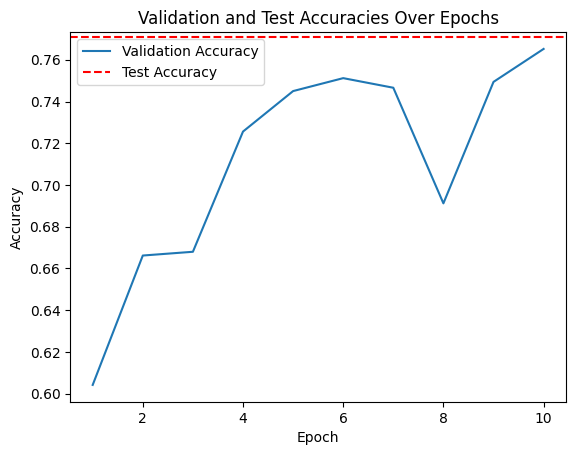

In [ ]:
import matplotlib.pyplot as plt

inputs = keras.Input(shape=(None,), dtype="int64")
embedded = embedding_layer(inputs)
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

callbacks = [
    keras.callbacks.ModelCheckpoint("glove_embeddings_sequence_model.keras",
                                    save_best_only=True)
]
history = model.fit(int_train_ds, validation_data=int_val_ds, epochs=10, callbacks=callbacks)
model = keras.models.load_model("glove_embeddings_sequence_model.keras")
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

# Extract validation and test accuracies from history
val_acc = history.history['val_accuracy']
test_acc = model.evaluate(int_test_ds)[1]

# Plotting
plt.plot(range(1, len(val_acc) + 1), val_acc, label='Validation Accuracy')
plt.axhline(y=test_acc, color='r', linestyle='--', label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation and Test Accuracies Over Epochs')
plt.legend()
plt.show()

Changing the number of training samples to determine at what point the
embedding layer gives better performance.

In [ ]:
import os
import pathlib
import random
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

Download the data

In [ ]:
!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz
!rm -r aclImdb/train/unsup

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  5033k      0  0:00:16  0:00:16 --:--:-- 5920k


Define directories

In [ ]:
base_dir = pathlib.Path("aclImdb")
train_dir = base_dir / "train"
test_dir = base_dir / "test"

Create train, val, and test datasets

In [ ]:
batch_size = 32
max_length = 150
max_tokens = 10000

# Training dataset
train_ds = keras.utils.text_dataset_from_directory(
    directory=train_dir,
    batch_size=batch_size,
    validation_split=0.2,
    subset="training",
    seed=1337,
    label_mode="binary",
)

# Validation dataset
val_ds = keras.utils.text_dataset_from_directory(
    directory=train_dir,
    batch_size=batch_size,
    validation_split=0.2,
    subset="validation",
    seed=1337,
    label_mode="binary",
)

# Test dataset
test_ds = keras.utils.text_dataset_from_directory(
    directory=test_dir,
    batch_size=batch_size,
    label_mode="binary",
)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


Define integer sequence datasets

In [ ]:
text_only_train_ds = train_ds.map(lambda x, y: x)

Prepare integer sequence datasets

In [ ]:
text_vectorization = layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=max_length,
)
text_vectorization.adapt(text_only_train_ds)

Define embedding layer

In [ ]:
embedding_dim = 100
path_to_glove_file = "glove.6B.100d.txt"
embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

vocabulary = text_vectorization.get_vocabulary()
word_index = dict(zip(vocabulary, range(len(vocabulary))))
embedding_matrix = np.zeros((max_tokens, embedding_dim))
for word, i in word_index.items():
    if i < max_tokens:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

embedding_layer = layers.Embedding(
    max_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
    mask_zero=True,
)

Define model architecture with one-hot encoding

In [ ]:
def get_one_hot_model():
    inputs = keras.Input(shape=(None,), dtype="int64")
    embedded = tf.one_hot(inputs, depth=max_tokens)
    x = layers.Bidirectional(layers.LSTM(32))(embedded)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer="rmsprop",
                  loss="binary_crossentropy",
                  metrics=["accuracy"])
    return model

Define model architecture with pretrained word embeddings

In [ ]:
def get_embedding_model():
    inputs = keras.Input(shape=(None,), dtype="int64")
    embedded = embedding_layer(inputs)
    x = layers.Bidirectional(layers.LSTM(32))(embedded)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer="rmsprop",
                  loss="binary_crossentropy",
                  metrics=["accuracy"])
    return model

Train and evaluate models with different numbers of training samples

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  3949k      0  0:00:20  0:00:20 --:--:-- 6279k
Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Number of training samples: 100
Validation accuracy: 0.806
Test accuracy: 0.790

Number of training samples: 500
Validation accuracy: 0.831
Test accuracy: 0.808

Number of training samples: 1000
Validation accuracy: 0.843
Test accuracy: 0.831

Number of training samples: 2000
Validation accuracy: 0.844
Test accuracy: 0.831

Number of training samples: 5000
Validation accuracy: 0.840
Test accuracy: 0.822

Number of training samples: 10000
Validation accuracy: 0.861
Test accuracy: 0.837



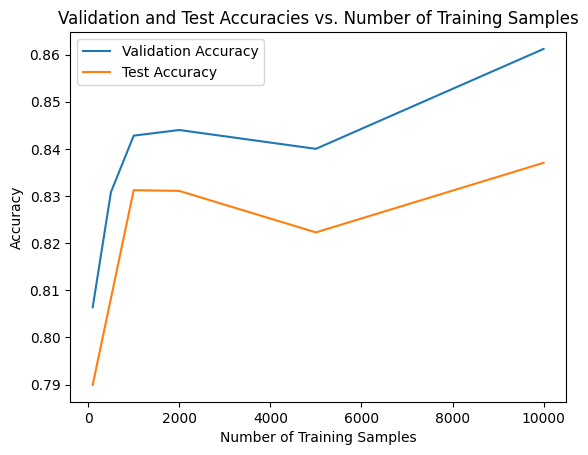

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt

# Define the number of training samples to try
num_training_samples = [100, 500, 1000, 2000, 5000, 10000]

# Define other constants
max_length = 150
max_tokens = 10000
batch_size = 32

# Download and extract the dataset
!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz
!rm -r aclImdb/train/unsup

# Load the dataset
train_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/train", batch_size=batch_size, validation_split=0.2, subset="training", seed=1337
)
val_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/train", batch_size=batch_size, validation_split=0.2, subset="validation", seed=1337
)

text_only_train_ds = train_ds.map(lambda x, y: x)

# Prepare the text vectorization layer
text_vectorization = layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=max_length,
)
text_vectorization.adapt(text_only_train_ds)

val_accuracies = []
test_accuracies = []

# Iterate over different numbers of training samples
for num_samples in num_training_samples:
    # Prepare the integer sequence datasets
    int_train_ds = train_ds.map(
        lambda x, y: (text_vectorization(x), y),
        num_parallel_calls=tf.data.AUTOTUNE
    ).take(num_samples)
    int_val_ds = val_ds.map(
        lambda x, y: (text_vectorization(x), y),
        num_parallel_calls=tf.data.AUTOTUNE
    )

    # Define the model
    inputs = keras.Input(shape=(None,), dtype="int64")
    embedded = layers.Embedding(input_dim=max_tokens, output_dim=256)(inputs)
    x = layers.Bidirectional(layers.LSTM(32))(embedded)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])

    # Train the model
    model.fit(int_train_ds, validation_data=int_val_ds, epochs=5, verbose=0)

    # Evaluate the model on validation and test sets
    val_accuracy = model.evaluate(int_val_ds, verbose=0)[1]
    test_accuracy = model.evaluate(int_test_ds, verbose=0)[1]

    val_accuracies.append(val_accuracy)
    test_accuracies.append(test_accuracy)

    # Print the results
    print(f"Number of training samples: {num_samples}")
    print(f"Validation accuracy: {val_accuracy:.3f}")
    print(f"Test accuracy: {test_accuracy:.3f}")
    print()

# Plotting
plt.plot(num_training_samples, val_accuracies, label='Validation Accuracy')
plt.plot(num_training_samples, test_accuracies, label='Test Accuracy')
plt.xlabel('Number of Training Samples')
plt.ylabel('Accuracy')
plt.title('Validation and Test Accuracies vs. Number of Training Samples')
plt.legend()
plt.show()